# **Natural Language Processing with Disaster Tweets**

Natural Language Processing (NLP) is a branch of machine learning that focuses on enabling machines to understand and process human language. In this project, we apply NLP techniques to participate in a Kaggle competition: [**Natural Language Processing with Disaster Tweets**](https://www.kaggle.com/competitions/nlp-getting-started/overview).

The goal of the competition is to **predict whether a given tweet is about a real disaster or not**. Although this may seem straightforward, tweets often contain informal language, abbreviations, and unique writing styles, making them difficult to interpret without deep linguistic understanding. Therefore, selecting and training the right model becomes critical.

The dataset provided consists entirely of textual data, which requires preprocessing and transformation before it can be fed into a classification model. NLP helps us clean and convert this text into a form that machine learning algorithms can understand and learn from.

### 📊 Dataset Overview

The dataset contains three main input features:
- **Keyword**: A relevant word extracted from the tweet (can be missing/NA)
- **Location**: The location from which the tweet was sent (can be missing/NA)
- **Text**: The actual content of the tweet

The target variable we aim to predict is:
- **Target**: A binary label indicating whether the tweet refers to a real disaster (`1`) or not (`0`)

There are **7,613** samples in the training set and **3,263** samples in the test set, which will be used to evaluate model performance on Kaggle.

---

This project aims not only to build accurate classifiers, but also to explore the power of modern NLP—from traditional models to transformer-based architectures like BERT—in understanding human language in social media contexts.


# Load Data

In [1]:
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import numpy as np

In [2]:
!pip install gdown

In [3]:
import gdown
url = 'https://drive.google.com/drive/folders/1sYCbmTNG8Tv2aLyFylvet8MHe7bZ-DOX?usp=drive_link'
gdown.download_folder(url)

df_train = pd.read_csv('/content/Data/train.csv')
df_test = pd.read_csv('/content/Data/test.csv')

Retrieving folder contents


Processing file 1q9V27zuXrk6PXyssjEUykl8VxZ-NEzFE data_bersih.csv
Processing file 1Nu_y9H_AWWQ6I0wVudceUJcPEcXYxWll test.csv
Processing file 1cj7_cwLKabUomtvnJsjBdqj4XJTaOh23 train.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1q9V27zuXrk6PXyssjEUykl8VxZ-NEzFE
To: /content/Data/data_bersih.csv
100%|██████████| 2.16M/2.16M [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nu_y9H_AWWQ6I0wVudceUJcPEcXYxWll
To: /content/Data/test.csv
100%|██████████| 421k/421k [00:00<00:00, 47.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cj7_cwLKabUomtvnJsjBdqj4XJTaOh23
To: /content/Data/train.csv
100%|██████████| 988k/988k [00:00<00:00, 39.5MB/s]
Download completed


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Preprocessing and EDA

In [6]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


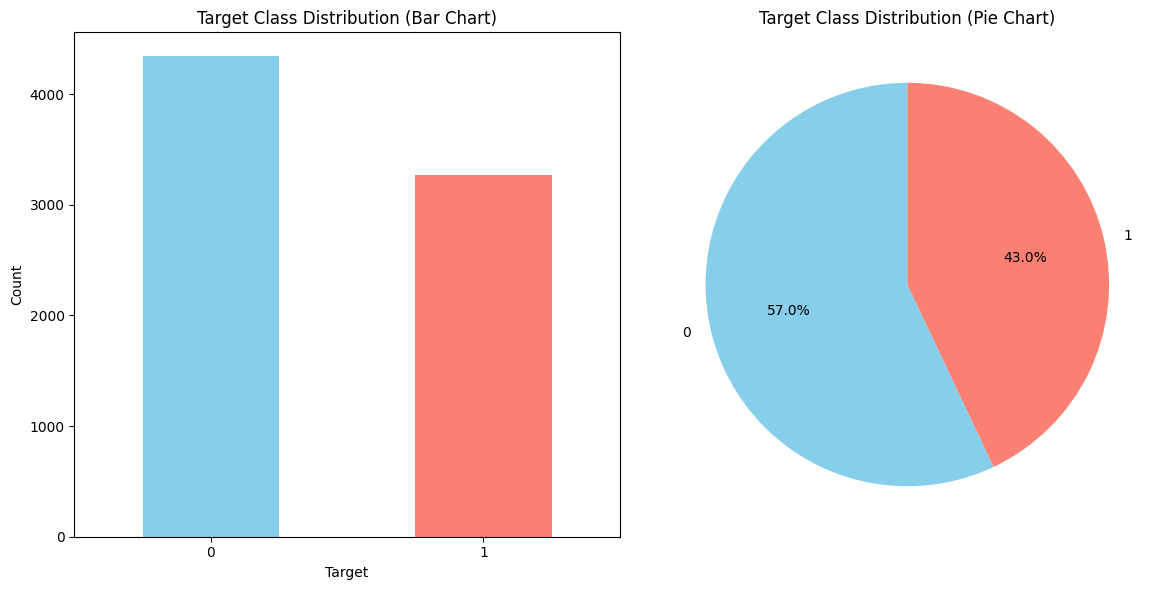

In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(df):
    target_counts = df['target'].value_counts()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot bar chart
    target_counts.plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[0])
    axes[0].set_title('Target Class Distribution (Bar Chart)')
    axes[0].set_xlabel('Target')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(target_counts.index, rotation=0)

    # Plot pie chart
    axes[1].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
    axes[1].set_title('Target Class Distribution (Pie Chart)')

    plt.tight_layout()
    plt.show()

plot_class_distribution(df_train)

43% of the observations are labeled as Disaster and 57% as Not Disaster.

Since the class distribution is relatively balanced and does not show significant disparity, imbalanced sampling techniques are not required prior to modeling.

In [8]:
print("Missing values in the training data by column:")
print(df_train.isna().sum())

print("\nMissing values in the test data by column:")
print(df_test.isna().sum())

Missing values in the training data by column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in the test data by column:
id             0
keyword       26
location    1105
text           0
dtype: int64


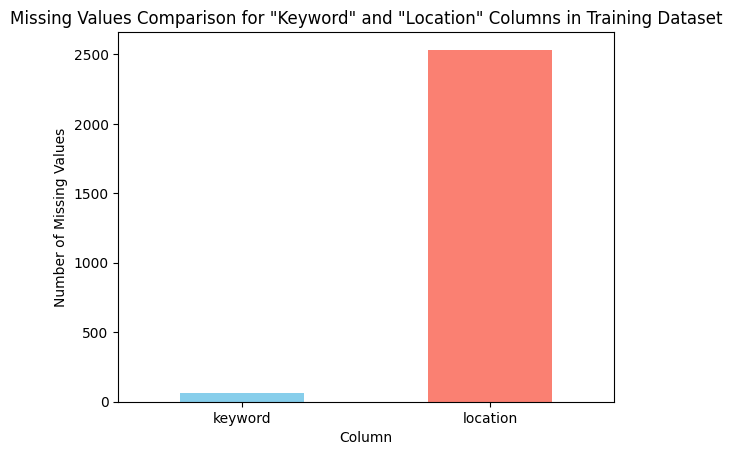

Missing values in 'keyword' column of the training dataset: 0.80%
Missing values in 'location' column of the training dataset: 33.27%


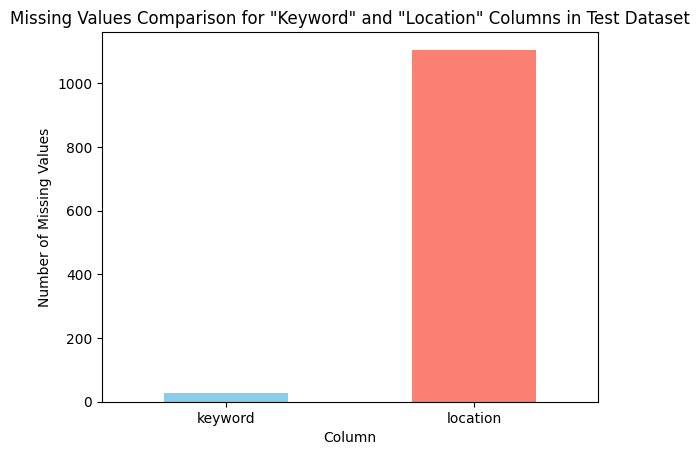

Missing values in 'keyword' column of the test dataset: 0.80%
Missing values in 'location' column of the test dataset: 33.86%


In [9]:
def plot_missing_values(df_train, df_test):
    missing_train = df_train[['keyword', 'location']].isna().sum()
    missing_test = df_test[['keyword', 'location']].isna().sum()

    # Plot missing values in training set
    missing_train.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Missing Values Comparison for "Keyword" and "Location" Columns in Training Dataset')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=0)
    plt.show()

    for col in missing_train.index:
        missing_percentage_train = (missing_train[col] / len(df_train)) * 100
        print(f"Missing values in '{col}' column of the training dataset: {missing_percentage_train:.2f}%")

    # Plot missing values in test set
    missing_test.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Missing Values Comparison for "Keyword" and "Location" Columns in Test Dataset')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=0)
    plt.show()

    for col in missing_test.index:
        missing_percentage_test = (missing_test[col] / len(df_test)) * 100
        print(f"Missing values in '{col}' column of the test dataset: {missing_percentage_test:.2f}%")

plot_missing_values(df_train, df_test)

The keyword column contains very few missing values and can generally be used without significant concern.

In contrast, the location column has a relatively high proportion of missing values — approximately one-third of the dataset. This should be considered during preprocessing, as it may affect model performance if not handled properly.

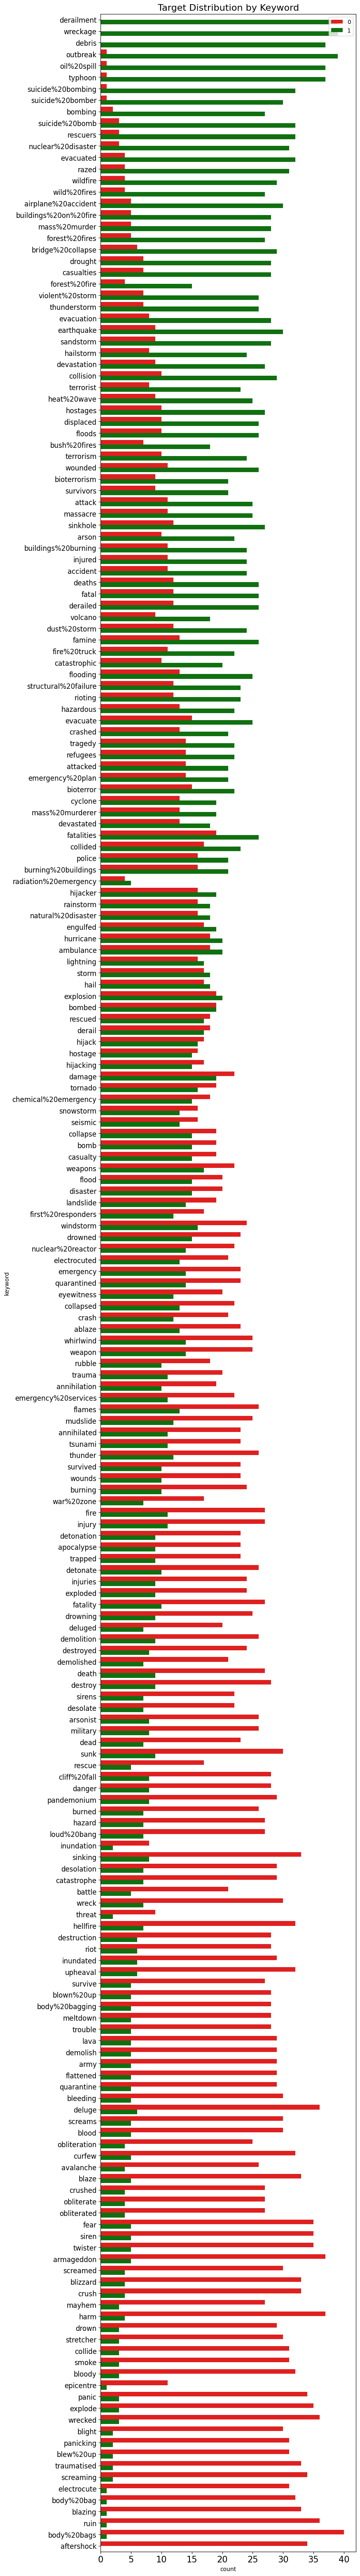

In [10]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig, ax = plt.subplots(figsize=(8, 80), dpi=100)
sorted_df = df_train.sort_values(by='target_mean', ascending=False)

sns.countplot(y=sorted_df['keyword'], hue=sorted_df['target'], ax=ax, palette=["red", "green"])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper right')
ax.set_title('Target Distribution by Keyword', fontsize=16)
plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

The distribution of target values for each keyword shows how frequently a particular keyword is associated with a disaster-related tweet (target = 1).

This helps us understand which keywords are strong indicators of real disaster events.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


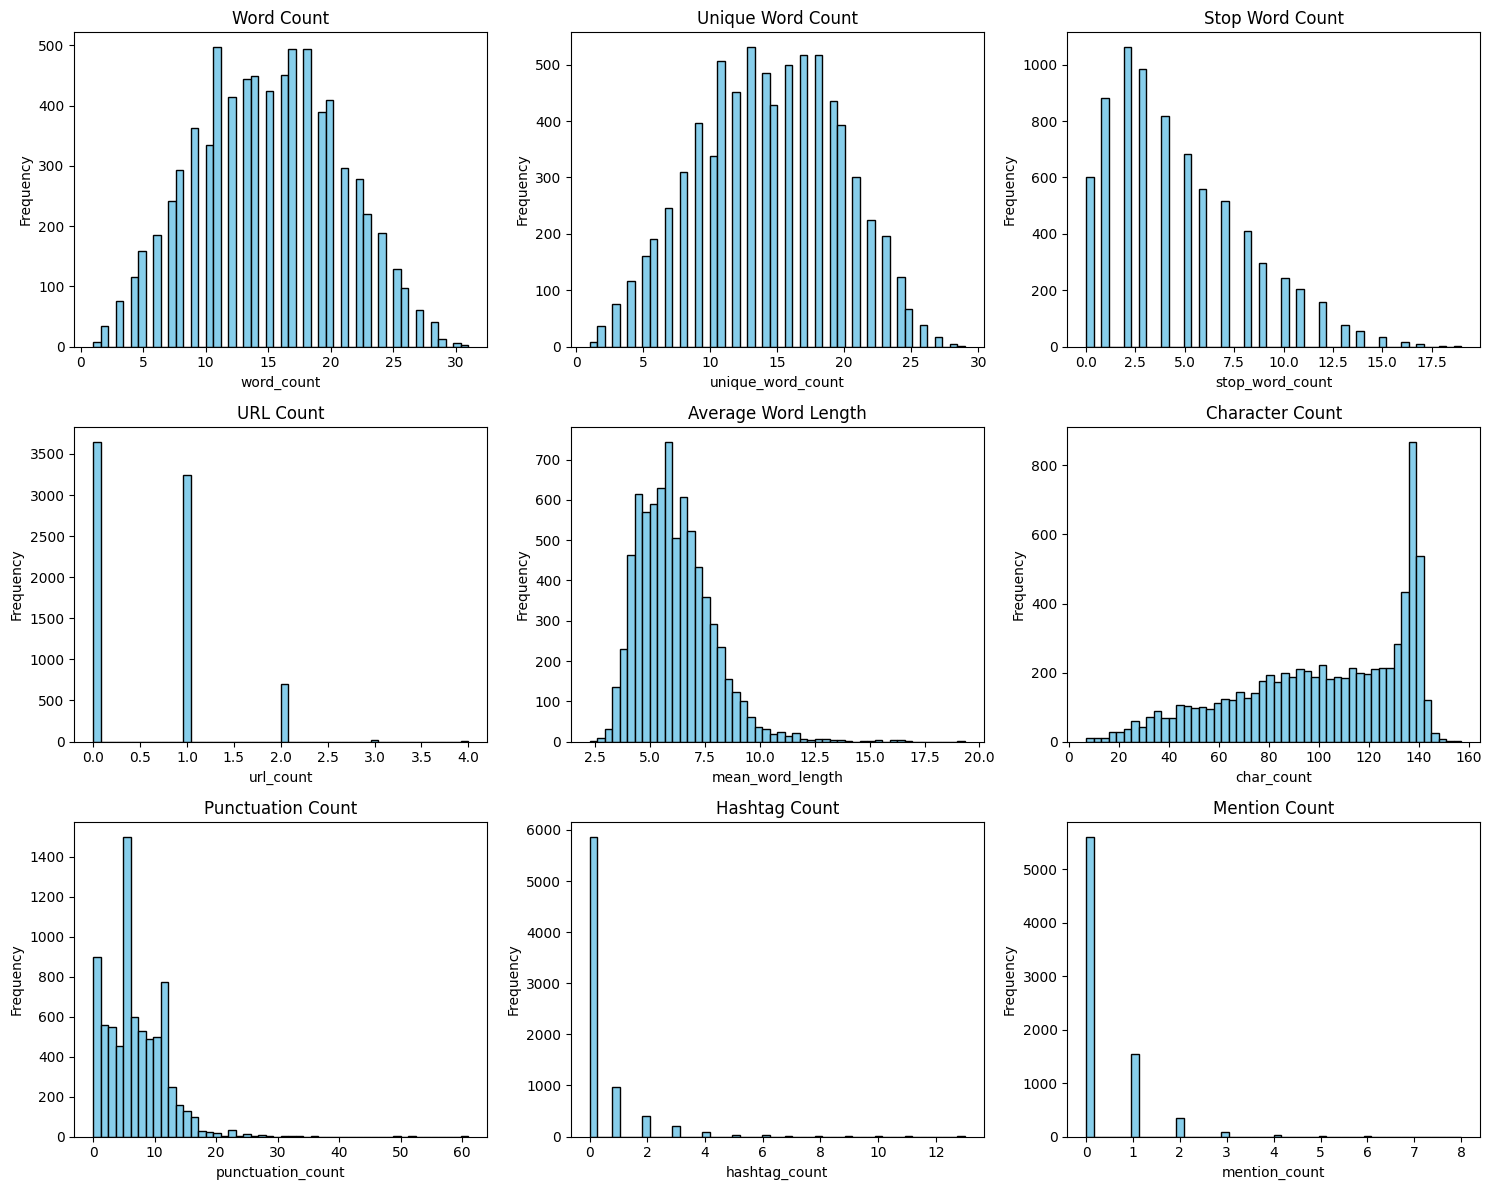

In [11]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to extract text-related features
def text_features(text):
    if isinstance(text, str):
        words = text.split()
        num_words = len(words)
        unique_words = len(set(words))
        stop_words_count = len([word for word in words if word.lower() in stop_words])
        urls = len(re.findall(r'http[s]?://\S+', text))
        mean_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        char_count = len(text)
        punctuation_count = len([char for char in text if char in string.punctuation])
        hashtag_count = len(re.findall(r'#\S+', text))
        mention_count = len(re.findall(r'@\S+', text))

        return {
            'word_count': num_words,
            'unique_word_count': unique_words,
            'stop_word_count': stop_words_count,
            'url_count': urls,
            'mean_word_length': mean_word_length,
            'char_count': char_count,
            'punctuation_count': punctuation_count,
            'hashtag_count': hashtag_count,
            'mention_count': mention_count
        }
    return {}

# Apply the feature extraction
df_train_features = df_train['text'].apply(text_features)
df_features = pd.json_normalize(df_train_features)
df_train = pd.concat([df_train, df_features], axis=1)

# Plot histograms for each feature
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
features = [
    'word_count', 'unique_word_count', 'stop_word_count',
    'url_count', 'mean_word_length', 'char_count',
    'punctuation_count', 'hashtag_count', 'mention_count'
]
titles = [
    'Word Count', 'Unique Word Count', 'Stop Word Count',
    'URL Count', 'Average Word Length', 'Character Count',
    'Punctuation Count', 'Hashtag Count', 'Mention Count'
]

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[i // 3, i % 3]
    df_train[feature].plot(kind='hist', bins=50, ax=ax, title=title, color='skyblue', edgecolor='black')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

| **Feature**                               | **Description**                                                                                  |
|-------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Word Count**                            | Most tweets contain between 10–20 words. The distribution is roughly normal (symmetric).        |
| **Unique Word Count**                     | The number of unique words closely follows the total word count (10–20 words). Also normally distributed. |
| **Stop Word Count**                       | Most tweets contain between 2–10 stopwords. The distribution is left-skewed.                    |
| **URL Count**                             | The majority of tweets contain no URLs. The distribution is highly concentrated at 0.           |
| **Average Word Length**                   | The average word length ranges from 4 to 7 characters. The distribution is approximately normal.|
| **Character Count**                       | Most tweets contain between 100–140 characters. The distribution is right-skewed.               |
| **Punctuation Count**                     | Most tweets have fewer than 10 punctuation marks. The distribution is left-skewed.              |
| **Hashtag Count**                         | Most tweets do not contain any hashtags. The distribution is concentrated at 0.                 |
| **Mention Count**                         | Most tweets contain 0–1 user mentions. The distribution is sharply centered around 0–1.         |


In [12]:
features = [
    ('Word Count', 'word_count'),
    ('Unique Word Count', 'unique_word_count'),
    ('Stop Word Count', 'stop_word_count'),
    ('URL Count', 'url_count'),
    ('Average Word Length', 'mean_word_length'),
    ('Character Count', 'char_count'),
    ('Punctuation Count', 'punctuation_count'),
    ('Hashtag Count', 'hashtag_count'),
    ('Mention Count', 'mention_count')
]

for description, key in features:
    print(f'{description}: {df_train[key].sum()}')

Word Count: 113461
Unique Word Count: 109176
Stop Word Count: 34890
URL Count: 4721
Average Word Length: 46656.22408545592
Character Count: 769198
Punctuation Count: 52069
Hashtag Count: 3375
Mention Count: 2722


The total values for each text feature are printed above to provide a quick summary of the dataset’s overall content structure.

## Cleaning



In [13]:
df_train = df_train.drop(columns=['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count'])

In [14]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [15]:
!pip install emoji
!pip install regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.0 MB/s eta 0:00:00


In [16]:
import regex as re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Replace mentions
    text = re.sub(r'@[^\s]+', 'atUser', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Replace emojis with space
    text = emoji.replace_emoji(text, replace=' ')

    # Handle CamelCase hashtags using Unicode regex
    def split_camel_case(word):
        matches = re.finditer('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|$)', word)
        return " ".join([m.group(0) for m in matches])

    # Normalize ellipsis
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')

    # Expand acronyms and slang
    acronyms = {
        "mh370": "Malaysia Airlines Flight 370",
        "mÌ¼sica": "music",
        "okwx": "Oklahoma City Weather",
        "arwx": "Arkansas Weather",
        "gawx": "Georgia Weather",
        "scwx": "South Carolina Weather",
        "cawx": "California Weather",
        "tnwx": "Tennessee Weather",
        "azwx": "Arizona Weather",
        "alwx": "Alabama Weather",
        "wordpressdotcom": "wordpress",
        "usnws gov": "United States National Weather Service",
        "suruc": "Sanliurfa",
        "w/e": "whatever",
        "w/": "with",
        "USAgov": "USA government",
        "recentlu": "recently",
        "Ph0tos": "Photos",
        "amirite": "am I right",
        "exp0sed": "exposed",
        "<3": "love",
        "lmao": "laughing my ass off",
    }
    for acro, full_form in acronyms.items():
        text = re.sub(re.escape(acro), full_form, text)

    # Replace corrupted or special characters
    special_chars = {
        "\x89Û_": "", "\x89ÛÒ": "", "\x89ÛÓ": "", "\x89ÛÏWhen": "When",
        "\x89ÛÏ": "", "å_": "", "\x89Û¢": "", "\x89Û¢åÊ": "", "åÊ": "",
        "åÈ": "", "JapÌ_n": "Japan", "Ì©": "e", "å¨": "", "SuruÌ¤": "Suruc",
        "åÇ": "", "å£3million": "3 million", "åÀ": "", "&gt;": ">",
        "&lt;": "<", "&amp;": "&"
    }
    text = re.sub('|'.join(re.escape(key) for key in special_chars.keys()), lambda x: special_chars[x.group()], text)

    # Remove emoji symbols (Unicode ranges)
    text = re.sub("["
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", ' ', text)

    # Process hashtags: remove # and split CamelCase
    words = text.split()
    processed_words = []
    for word in words:
        if word.startswith("#"):
            word_no_hashtag = word[1:]
            word_processed = split_camel_case(word_no_hashtag)
            processed_words.append(word_processed)
        else:
            processed_words.append(word)
    text = " ".join(processed_words)

    # Expand contractions
    contractions = {
        r"\bhe's\b": "he is", r"\bthere's\b": "there is", r"\bwe're\b": "we are", r"\bthat's\b": "that is",
        r"\bwon't\b": "will not", r"\bthey're\b": "they are", r"\bcan't\b": "cannot", r"\bwasn't\b": "was not",
        r"\bdon\x89Ûªt\b": "do not", r"\baren't\b": "are not", r"\bisn't\b": "is not", r"\bwhat's\b": "what is",
        r"\bhaven't\b": "have not", r"\bhasn't\b": "has not", r"\bit's\b": "it is", r"\byou're\b": "you are",
        r"\bshouldn't\b": "should not", r"\bwouldn't\b": "would not", r"\bi'm\b": "I am", r"\bhere's\b": "here is",
        r"\byou've\b": "you have", r"\bcouldn't\b": "could not", r"\bwe've\b": "we have", r"\bdoesn't\b": "does not",
        r"\bwho's\b": "who is", r"\by'all\b": "you all", r"\bwould've\b": "would have", r"\bit'll\b": "it will",
        r"\bwe'll\b": "we will", r"\bhe'll\b": "he will", r"\bweren't\b": "were not", r"\bdidn't\b": "did not",
        r"\bthey'll\b": "they will", r"\bthey'd\b": "they would", r"\bthey've\b": "they have", r"\bi'd\b": "I would",
        r"\bshould've\b": "should have", r"\bwhere's\b": "where is", r"\bwe'd\b": "we would", r"\bi'll\b": "I will",
        r"\byou'll\b": "you will", r"\byou'd\b": "you would", r"\bain't\b": "am not", r"\bcould've\b": "could have",
        r"\byouve\b": "you have", r"\bdonå«t\b": "do not"
    }
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    # Lowercase and strip whitespaces
    text = text.lower().strip()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove punctuation and digits
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Stopwords and punctuation are removed to reduce noise in the text.

Then, each word is simplified to its base or dictionary form using lemmatization, which helps in standardizing the vocabulary for more effective text analysis.

In [17]:
df['cleaned_text'] = df['text'].apply(clean_text)
df

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,earthquake safety los angeles safety fastener ...
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,storm ri worse last hurricane city others hard...
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,green line derailment chicago
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,meg issue hazardous weather outlook hwo


In [18]:
df['Dataset'] = df['target'].apply(lambda x: 'train' if pd.notna(x) else 'test')

## Misleading

In [19]:
# Filter data where 'Dataset' column equals 'train'
train_data = df[df['Dataset'] == 'train']

# Find duplicate rows based on the 'text' column
duplicates_with_diff_targets = train_data[train_data.duplicated(subset=['text'], keep=False)]

# Filter duplicates that have different 'target' values
# Group by 'text' and keep groups with more than one unique target
conflicting_duplicates = duplicates_with_diff_targets.groupby('text').filter(
    lambda x: x['target'].nunique() > 1
)

# Drop redundant entries for display purposes
unique_conflicting_duplicates = conflicting_duplicates.drop_duplicates(subset=['text'])

# Show relevant columns
result = unique_conflicting_duplicates[['keyword', 'text', 'target']]
result

,keyword,text,target
610,bioterrorism,To fight bioterrorism sir.,1.0
1197,buildings%20burning,Mmmmmm I'm burning.... I'm burning buildings I...,1.0
1214,buildings%20burning,I Pledge Allegiance To The P.O.P.E. And The Bu...,0.0
1221,buildings%20burning,like for the music video I want some real acti...,1.0
2830,displaced,.POTUS #StrategicPatience is a strategy for #G...,1.0
3240,engulfed,He came to a land which was engulfed in tribal...,0.0
3985,floods,Who is bringing the tornadoes and floods. Who ...,1.0
4221,hazardous,#foodscare #offers2go #NestleIndia slips into ...,1.0
4232,hazardous,Caution: breathing may be hazardous to your he...,1.0
4284,hellfire,The Prophet (peace be upon him) said 'Save you...,0.0


In [20]:
# List of text entries and their corrected target labels
update_list = [
    ("like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit", 0),
    ("Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife", 0),
    ("To fight bioterrorism sir.", 0),
    (".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4", 1),
    ("#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption", 0),
    ("In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!", 0),
    ("RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG", 1),
    ("Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 0),
    ("wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 0),
    ("He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 0),
    ("Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 0),
    ("The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 0),
    ("Caution: breathing may be hazardous to your health.", 1),
    ("I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 0),
    ("#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 0),
    ("that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 0),
    ("CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring", 1),
    ("Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE", 1)
]

# Convert list to dictionary for mapping
update_dict = dict(update_list)

# Select only training data
df_train = df[df['Dataset'] == 'train']

# Update target values for matching text entries
df_train.loc[df_train['text'].isin(update_dict.keys()), 'target'] = df_train['text'].map(update_dict)

# Apply the updated targets back to the original dataframe
df_updated = df.copy()
df_updated.loc[df_train.index, 'target'] = df_train['target']

A number of tweet samples in the training dataset were identified with incorrect or inconsistent target labels.

These entries have been manually reviewed and updated with corrected labels using a predefined list of known corrections.

This step helps improve model accuracy by eliminating noisy or mislabeled training data.

In [21]:
df_updated.to_csv('data_bersih.csv', index=False)

## N-grams

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to extract top N n-grams (1, 2, or 3-grams) excluding specific words
def top_ngrams(data, n, grams, exclude_words=None):
    if exclude_words is None:
        exclude_words = []
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in exclude_words]))
    count_vec = CountVectorizer(ngram_range=(grams, grams)).fit(data)
    bow = count_vec.transform(data)
    word_freq = [(word, bow.sum(axis=0)[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]

# List of words to exclude from n-gram counting
exclude_words = ['atuser']

# Extract top 20 unigrams, bigrams, and trigrams
common_uni = top_ngrams(df_updated["cleaned_text"], 20, 1, exclude_words)
common_bi = top_ngrams(df_updated["cleaned_text"], 20, 2, exclude_words)
common_tri = top_ngrams(df_updated["cleaned_text"], 20, 3, exclude_words)

# Convert to DataFrames for visualization
common_uni_df = pd.DataFrame(common_uni, columns=['word', 'freq'])
common_bi_df = pd.DataFrame(common_bi, columns=['word', 'freq'])
common_tri_df = pd.DataFrame(common_tri, columns=['word', 'freq'])

# Create subplots for unigrams, bigrams, and trigrams
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Top 20 Unigrams", "Top 20 Bigrams", "Top 20 Trigrams")
)

# Add bar charts
fig.add_trace(
    go.Bar(
        x=common_uni_df["word"],
        y=common_uni_df["freq"],
        marker=dict(color='rgba(255, 170, 59, 0.8)'),
        marker_line=dict(color='black'),
        marker_line_width=1.2
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=common_bi_df["word"],
        y=common_bi_df["freq"],
        marker=dict(color='rgba(89, 255, 147, 0.8)'),
        marker_line=dict(color='black'),
        marker_line_width=1.2
    ),
    row=2, col=1
)

fig.add_trace(
    go.Bar(
        x=common_tri_df["word"],
        y=common_tri_df["freq"],
        marker=dict(color='rgba(89, 153, 255, 0.8)'),
        marker_line=dict(color='black'),
        marker_line_width=1.2
    ),
    row=3, col=1
)

# Update layout and display
fig.update_layout(
    title_text="Top 20 Unigrams, Bigrams, and Trigrams",
    title_x=0.5,
    showlegend=False,
    width=800,
    height=1200
).update_xaxes(tickangle=-45)

fig.show()


| **Feature**                            | **Description**                                                                                           |
|----------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **Top 20 Unigrams** (Single Words)     | The most frequent words include "like", "fire", and "news", indicating dominant topics such as news or disasters. |
|                                        | Terms like "attack", "emergency", and "disaster" suggest the tweets often relate to emergencies or negative events. |
| **Top 20 Bigrams** (Word Pairs)        | Frequent bigrams include "suicide bomber", "look like", and "book bag".                                   |
|                                        | Many word pairs are linked to disasters, criminal acts, or emergencies, such as "natural disaster" and "mass murder". |
| **Top 20 Trigrams** (Three-Word Phrases)| Common trigrams include "suicide bomber detonate" and "northern california wildfire".                     |
|                                        | Several trigrams refer to specific incidents, such as "PKK suicide bomber" and "natural disaster response". |

# Modeling

In [24]:
data = pd.read_csv('/content/Data/data_bersih.csv')

In [25]:
data_train = data[data['Dataset'] == 'train'][['id', 'cleaned_text', 'target']]
print("Data Train:", data_train.shape)
data_train

Data Train: (7613, 3)


,id,cleaned_text,target
0,1,deed reason earthquake may allah forgive u,1.0
1,4,forest fire near la ronge sask canada,1.0
2,5,resident asked shelter place notified officer ...,1.0
3,6,people receive wildfire evacuation order calif...,1.0
4,7,got sent photo ruby alaska smoke wildfire pour...,1.0
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,1.0
7609,10870,atuser atuser control wild fire california eve...,1.0
7610,10871,utc km volcano hawaii,1.0
7611,10872,police investigating e bike collided car littl...,1.0


In [26]:
data_test = data[data['Dataset'] == 'test'][['id', 'cleaned_text']]
print("Data Test:", data_test.shape)
data_test

Data Test: (3263, 2)


,id,cleaned_text
7613,0,happened terrible car crash
7614,2,heard earthquake different city stay safe ever...
7615,3,forest fire spot pond goose fleeing across str...
7616,9,apocalypse lighting spokane wildfire
7617,11,typhoon soudelor kill china taiwan
...,...,...
10871,10861,earthquake safety los angeles safety fastener ...
10872,10865,storm ri worse last hurricane city others hard...
10873,10868,green line derailment chicago
10874,10874,meg issue hazardous weather outlook hwo


In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from lightgbm import LGBMClassifier

# Split data into features and target
X_train_raw = data_train['cleaned_text']
y_train = data_train['target']
X_test_raw = data_test['cleaned_text']
test_ids = data_test['id']

# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

Before applying machine learning models to predict the target variable, the text data is converted into numerical form using TF-IDF vectorization with both unigrams and bigrams.

This process captures not only individual word importance but

In [ ]:
# Define Baseline Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB()
}

# Model Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(f"Model: {name}")
    print(classification_report(y_train, y_pred))

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      4348
         1.0       0.93      0.78      0.85      3265

    accuracy                           0.88      7613
   macro avg       0.89      0.87      0.87      7613
weighted avg       0.89      0.88      0.88      7613

Model: Random Forest
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4348
         1.0       0.99      0.97      0.98      3265

    accuracy                           0.99      7613
   macro avg       0.99      0.98      0.99      7613
weighted avg       0.99      0.99      0.99      7613

Model: Decision Tree
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4348
         1.0       1.00      0.97      0.98      3265

    accuracy                           0.99      7613
   macro avg       0.99      0.98      0.99      7613
weigh

### 🔍 Evaluation of Baseline Models

#### 1. **Logistic Regression**

- **Strengths**:  
  The recall for class `0` is very high (**0.96**), indicating that the model performs well in identifying non-disaster tweets.

- **Weaknesses**:  
  The F1-score for class `1` is only **0.78**, suggesting that the model struggles more with identifying disaster-related tweets.

- **Overall Accuracy**: **0.89** — quite good, but there is a noticeable performance imbalance between the two classes.

---

#### 2. **Random Forest**

- **Strengths**:  
  Precision, recall, and F1-score are all very high for both classes (around **0.99** across the board).

- **Overall Accuracy**: **0.99** — extremely accurate.  
  This model shows the **best overall performance**, maintaining excellent balance between disaster and non-disaster predictions.

---

#### 3. **Decision Tree**

- **Strengths**:  
  Similar to Random Forest, the precision, recall, and F1-score are extremely high (ranging from **0.99 to 1.0**).

- **Overall Accuracy**: **0.99** — nearly identical to Random Forest.  
  Although performance is strong, the Decision Tree is **simpler** and more prone to **overfitting** the training data.

---

#### 4. **Support Vector Machine (SVM)**

- **Strengths**:  
  Precision and recall are both strong for class `0` and `1` (between **0.94 and 0.96**).

- **Weaknesses**:  
  Slightly underperforms compared to ensemble models, especially in **recall for class 1 (0.94)**.

- **Overall Accuracy**: **0.96**  
  SVM offers solid performance, though not as optimal as Random Forest or Decision Tree.

---

#### 5. **Naive Bayes**

- **Strengths**:  
  Class `1` precision is fairly good (**0.94**).

- **Weaknesses**:  
  Lower performance for class `0` — recall is **0.83** and F1-score is **0.87**.

- **Overall Accuracy**: **0.88**, the lowest among all baseline models.  
  Naive Bayes is **less suitable** for this dataset due to inconsistent performance, especially in identifying non-disaster tweets.

## Hyperparameter Tuning

Hyperparameter tuning is the process of finding the best combination of parameters that are **not learned by the model during training**.  
These parameters are controlled by the user and can significantly influence the model's performance.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
# Hyperparameter Tuning untuk Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs', 'saga']}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)
print("Best Logistic Regression parameters:", grid_lr.best_params_)

# Classification report using the best parameters
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_train)
print("Classification Report for Logistic Regression:\n", classification_report(y_train, y_pred_lr))

Best Logistic Regression parameters: {'C': 10, 'solver': 'saga'}
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      4348
         1.0       0.97      0.92      0.94      3265

    accuracy                           0.95      7613
   macro avg       0.96      0.95      0.95      7613
weighted avg       0.95      0.95      0.95      7613



In [ ]:
# Hyperparameter Tuning untuk Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(X_train, y_train)
print("Best Random Forest parameters:", grid_rf.best_params_)

# Classification report using the best parameters
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_train)
print("Classification Report for Random Forest:\n", classification_report(y_train, y_pred_rf))

Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report for Random Forest:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4348
         1.0       0.99      0.97      0.98      3265

    accuracy                           0.98      7613
   macro avg       0.99      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613



In [ ]:
# Hyperparameter Tuning untuk Decision Tree
param_grid_dtc = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid_dtc, cv=5, scoring='f1')
grid_dtc.fit(X_train, y_train)
print("Best Decision Tree parameters:", grid_dtc.best_params_)

# Classification report using the best parameters
best_dtc = grid_dtc.best_estimator_
y_pred_dtc = best_dtc.predict(X_train)
print("Classification Report for Decision Tree:\n", classification_report(y_train, y_pred_dtc))

Best Decision Tree parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report for Decision Tree:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4348
         1.0       1.00      0.97      0.98      3265

    accuracy                           0.99      7613
   macro avg       0.99      0.98      0.99      7613
weighted avg       0.99      0.99      0.99      7613



In [ ]:
# Hyperparameter Tuning untuk SVM
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='f1')
grid_svc.fit(X_train, y_train)
print("Best SVM parameters:", grid_svc.best_params_)

# Classification report using the best parameters
best_svc = grid_svc.best_estimator_
y_pred_svc = best_svc.predict(X_train)
print("Classification Report for SVM:\n", classification_report(y_train, y_pred_svc))

Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report for SVM:
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      4348
         1.0       0.95      0.83      0.88      3265

    accuracy                           0.91      7613
   macro avg       0.91      0.90      0.90      7613
weighted avg       0.91      0.91      0.91      7613



In [ ]:
# Hyperparameter Tuning untuk Naive Bayes
param_grid_nb = {'alpha': [0.01, 0.1, 1, 10]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1')
grid_nb.fit(X_train, y_train)
print("Best Naive Bayes parameters:", grid_nb.best_params_)

# Classification report using the best parameters
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_train)
print("Classification Report for Naive Bayes:\n", classification_report(y_train, y_pred_nb))

Best Naive Bayes parameters: {'alpha': 0.1}
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      4348
         1.0       0.94      0.80      0.86      3265

    accuracy                           0.89      7613
   macro avg       0.90      0.88      0.89      7613
weighted avg       0.90      0.89      0.89      7613



## Boosting

In [ ]:
import xgboost as xgb

# Boosting: XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("XGBoost Evaluation:")
print(classification_report(y_train, xgb_model.predict(X_train)))

XGBoost Evaluation:
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4348
         1.0       0.95      0.72      0.82      3265

    accuracy                           0.86      7613
   macro avg       0.88      0.84      0.85      7613
weighted avg       0.87      0.86      0.86      7613



In [ ]:
from lightgbm import LGBMClassifier

# Boosting: LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
print("LightGBM Evaluation:")
print(classification_report(y_train, lgb_model.predict(X_train)))

[LightGBM] [Info] Number of positive: 3265, number of negative: 4348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10584
[LightGBM] [Info] Number of data points in the train set: 7613, number of used features: 765
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428872 -> initscore=-0.286456
[LightGBM] [Info] Start training from score -0.286456
LightGBM Evaluation:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      4348
         1.0       0.90      0.74      0.81      3265

    accuracy                           0.85      7613
   macro avg       0.86      0.84      0.84      7613
weighted avg       0.86      0.85      0.85      7613



## Ensemble

In [ ]:
from sklearn.metrics import classification_report

def get_classification_report(model, X, y):
    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    return report

model_reports = {
    "Logistic Regression": get_classification_report(best_lr, X_train, y_train),
    "Random Forest": get_classification_report(best_rf, X_train, y_train),
    "XGBoost": get_classification_report(xgb_model, X_train, y_train),
    "LightGBM": get_classification_report(lgb_model, X_train, y_train),
    "Decision Tree": get_classification_report(best_dtc, X_train, y_train),
    "SVM": get_classification_report(best_svc, X_train, y_train),
    "Naive Bayes": get_classification_report(best_nb, X_train, y_train)
}

# Collect average scores for ranking
model_scores = {}
for model_name, report in model_reports.items():
    model_scores[model_name] = {
        "Accuracy": report['accuracy'],
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1 Score": report['weighted avg']['f1-score'],
        "Average Score": (report['accuracy'] + report['weighted avg']['precision'] + report['weighted avg']['recall'] + report['weighted avg']['f1-score']) / 4
    }

sorted_models = sorted(model_scores.items(), key=lambda x: x[1]['Average Score'], reverse=True)
print("Model Rankings:")
for model, scores in sorted_models:
    print(f"{model}: Average Score = {scores['Average Score']:.4f}")

Model Rankings:
Decision Tree: Average Score = 0.9864
Random Forest: Average Score = 0.9839
Logistic Regression: Average Score = 0.9532
SVM: Average Score = 0.9072
Naive Bayes: Average Score = 0.8928
XGBoost: Average Score = 0.8635
LightGBM: Average Score = 0.8520


In [ ]:
from sklearn.ensemble import VotingClassifier

# Select the top three models based on their ranking
top_three_models = [model[0] for model in sorted_models[:3]]
print("Top 3 Models Selected:", top_three_models)

estimators = [(model, models[model]) for model in top_three_models]

ensemble = VotingClassifier(estimators=estimators, voting='hard')
ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_train)
print("Ensemble Classification Report:\n", classification_report(y_train, y_pred_ensemble))

Top 3 Models Selected: ['Decision Tree', 'Random Forest', 'Logistic Regression']
Ensemble Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4348
         1.0       0.99      0.97      0.98      3265

    accuracy                           0.98      7613
   macro avg       0.99      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613



### ✅ Final Prediction with Voting Classifier

For the final prediction, we use an ensemble model combining **Decision Tree**, **Random Forest**, and **Logistic Regression** through a **Voting Classifier** approach.

The ensemble model delivers excellent performance with **high accuracy** and a **well-balanced classification** between class `0` (non-disaster) and class `1` (disaster).  
Compared to individual models, the ensemble benefits from the strengths of each:
- **Random Forest** for generalization,
- **Decision Tree** for interpretability and decision precision, and
- **Logistic Regression** for its simplicity and flexibility.

> ✅ This model achieves an accuracy of **0.98**.


In [ ]:
y_pred_test = ensemble.predict(X_test).astype(int)

results = pd.DataFrame({
    'id': test_ids,
    'target': y_pred_test
})
results

,id,target
7613,0,1
7614,2,1
7615,3,1
7616,9,1
7617,11,1
...,...,...
10871,10861,1
10872,10865,1
10873,10868,1
10874,10874,1


In [ ]:
results.to_csv('submission1.csv', index=False)
print("File 'submission1.csv' has been saved successfully.")

File 'submission1.csv' has been saved successfully.


# Modeling pakai BERT

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LENGTH = 128

class TweetDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()

        if self.labels is not None:
            label = torch.tensor(self.labels[item], dtype=torch.long)
            return dict(input_ids=input_ids, attention_mask=attention_mask, label=label)
        else:
            return dict(input_ids=input_ids, attention_mask=attention_mask)

train_dataset = TweetDataset(texts=X_train_raw.values, labels=y_train.values, tokenizer=tokenizer, max_len=MAX_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

train_accuracy, train_loss = train_epoch(model, train_dataloader, optimizer, device)
print(f'Training accuracy: {train_accuracy.item():.4f}, Training loss: {train_loss:.4f}')

def predict(model, texts, tokenizer, max_len=128):
    model = model.eval()
    predictions = []

    dataset = TweetDataset(texts=texts, tokenizer=tokenizer, max_len=max_len)
    dataloader = DataLoader(dataset, batch_size=16)

    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

    return predictions

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 476/476 [2:49:47<00:00, 21.40s/it]

Training accuracy: 0.8056, Training loss: 0.4463


In [ ]:
# Predict on test data
test_predictions = predict(model, X_test_raw.values, tokenizer)
test_predictions = [int(pred) for pred in test_predictions]

submission = pd.DataFrame({
    'id': test_ids,
    'target': test_predictions
})

In [ ]:
submission.to_csv('/content/submission.csv', index=False)